In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

import kagglehub

# Point KaggleHub to the current folder where kaggle.json is located
os.environ["KAGGLE_CONFIG_DIR"] = os.getcwd()

# Download the dataset - Different dataset used, and splitting handled manually
# path = kagglehub.dataset_download("evilspirit05/ecg-analysis")
path = kagglehub.dataset_download("drkhaledmohsin/national-heart-foundation-2023-ecg-dataset")

print("Dataset downloaded successfully!")
print("Path to dataset files:", path)

/home/oconnecs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded successfully!
Path to dataset files: /home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1


In [7]:
# List the contents of the dataset root folder
for root, dirs, files in os.walk(path):
    print(f"Folder: {root}")
    print(f"  Subfolders: {dirs[:5]}")
    print(f"  Files: {files[:5]}")
    # break  # remove 'break' if you want to see full structure

Folder: /home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1
  Subfolders: ['ECG Data']
  Files: []
Folder: /home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data
  Subfolders: ['Myocardial Infarction Patients', 'Patient that have History of Myocardial Infraction', 'Normal Person', 'split_dataset', 'Abnormal Heartbeat Patients']
  Files: []
Folder: /home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/Myocardial Infarction Patients
  Subfolders: []
  Files: ['MI(407).jpg', 'MI(123) - Copy.jpg', 'MI(198).jpg', 'MI(223) - Copy.jpg', 'MI(73) - Copy.jpg']
Folder: /home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/Patient that have History of Myocardial Infraction
  Subfolders: []
  Files: ['PMI(185) - Copy.jpg', 'PMI(90) - Copy.jpg', 'PMI(2

In [8]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [9]:
# Transformations (InceptionV3 requires 299x299 input)
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

# --- CONFIG ---
base_dir = "/home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data"
split_dir = os.path.join(base_dir, "split_dataset")
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# --- CREATE SPLIT FOLDERS ---
for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dir, split)
    os.makedirs(split_path, exist_ok=True)

# --- LOOP THROUGH EACH CLASS FOLDER ---
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # skip non-folder files

    # Get all image file paths
    images = [os.path.join(class_path, f)
              for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(images) == 0:
        print(f" No images found in {class_path}, skipping...")
        continue

    print(f"{class_name}: {len(images)} images found")

    # Split the dataset
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

    # Create class subfolders in each split folder
    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(split_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(img, split_class_dir)

print("\n Dataset successfully split into train/val/test sets at:", split_dir)

Myocardial Infarction Patients: 716 images found
Patient that have History of Myocardial Infraction: 516 images found
Normal Person: 852 images found
 No images found in /home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/split_dataset, skipping...
Abnormal Heartbeat Patients: 814 images found

 Dataset successfully split into train/val/test sets at: /home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/split_dataset


In [23]:
# --- Dataset Class ---
class ECGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # Define consistent mapping
        class_map = {
            "patient that have history of myocardial infraction": 0,
            "abnormal heartbeat patients": 1,
            "myocardial infarction patients": 2,
            "normal person": 3
        }

        # Traverse dataset directory, handle case-insensitivity
        for subdir in os.listdir(root_dir):
            subdir_lower = subdir.lower().strip()
            for class_name, label in class_map.items():
                if class_name in subdir_lower:
                    class_dir = os.path.join(root_dir, subdir)
                    for file in os.listdir(class_dir):
                        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                            self.image_paths.append(os.path.join(class_dir, file))
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label


# --- Define paths ---
train_dir = "/home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/split_dataset/train"
val_dir   = "/home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/split_dataset/val"
test_dir  = "/home/oconnecs/.cache/kagglehub/datasets/drkhaledmohsin/national-heart-foundation-2023-ecg-dataset/versions/1/ECG Data/split_dataset/test"

# --- Define transforms ---
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- Create Datasets ---
train_dataset = ECGDataset(train_dir, transform=transform)
val_dataset   = ECGDataset(val_dir, transform=transform)
test_dataset  = ECGDataset(test_dir, transform=transform)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 2027
Validation size: 434
Test size: 437


In [24]:
from torch.utils.data import DataLoader

# --- DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Dataset summary:")
print(f"  Train size: {len(train_dataset)} images")
print(f"  Validation size: {len(val_dataset)} images")
print(f"  Test size: {len(test_dataset)} images")

Dataset summary:
  Train size: 2027 images
  Validation size: 434 images
  Test size: 437 images


In [25]:
# Load InceptionV3 pretrained on ImageNet
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

# Freeze base layers to keep pretrained features
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 4)  # 4-class classification
)

# InceptionV3 also has an auxiliary classifier (for training stability)
num_aux_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_aux_ftrs, 4)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model ready on device: {device}")

Model ready on device: cuda


In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler: reduce LR by 0.5 every 3 epochs
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Early stopping setup
best_val_loss = float('inf')
patience = 3
trigger_times = 0

In [27]:
# Gradual unfreezing setup
def unfreeze_layers(model, n_unfreeze_blocks=1):
    """
    Unfreezes the last n_inception blocks of InceptionV3 for fine-tuning.
    """
    # Each Inception block is part of the mixed modules (e.g., Mixed_5b, Mixed_6a, etc.)
    inception_blocks = [model.Mixed_5b, model.Mixed_5c, model.Mixed_5d,
                        model.Mixed_6a, model.Mixed_6b, model.Mixed_6c, model.Mixed_6d, model.Mixed_6e,
                        model.Mixed_7a, model.Mixed_7b, model.Mixed_7c]

    # Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last `n_unfreeze_blocks`
    for block in inception_blocks[-n_unfreeze_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    print(f"Unfroze the last {n_unfreeze_blocks} inception blocks for fine-tuning.")


# Example: start frozen, unfreeze gradually
epochs_before_unfreeze = 5  # train only the classifier for 5 epochs
unfreeze_schedule = [1, 3, 5]  # number of inception blocks to unfreeze at milestones

In [28]:
from tqdm import tqdm

# --- Hyperparameters ---
num_epochs = 15
learning_rate = 1e-4
weight_decay = 1e-5
patience = 3  # early stopping patience

# --- Optimizer and Loss ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# --- Learning Rate Scheduler (reduce LR when val_loss plateaus) ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # reduce LR by half each time plateau occurs
    patience=2,       # wait 2 epochs with no improvement before reducing LR
    min_lr=1e-6       # lower bound on learning rate
)

# --- Tracking variables ---
train_losses, val_losses = [], []
best_val_loss = float('inf')
trigger_times = 0
prev_lr = optimizer.param_groups[0]['lr']

# --- Training Loop ---
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # Gradual unfreezing trigger
    if epoch+1 in [epochs_before_unfreeze + i*3 for i in range(len(unfreeze_schedule))]:
        n_blocks = unfreeze_schedule.pop(0)
        unfreeze_layers(model, n_unfreeze_blocks=n_blocks)
        # Reinitialize optimizer to include newly trainable layers
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                               lr=1e-5, weight_decay=1e-5)

    # ----- TRAIN -----
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass — InceptionV3 gives 2 outputs during training
        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # auxiliary loss weighted at 0.4

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ----- VALIDATION -----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # only main output during eval
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # --- Early stopping ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_inceptionv3_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

    # --- Scheduler step (based on validation loss) ---
    scheduler.step(epoch_val_loss)

    # --- Check if learning rate changed ---
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != prev_lr:
        print(f"Learning rate reduced: {prev_lr:.6f} → {current_lr:.6f}")
        prev_lr = current_lr

print("\n Training complete.")


Epoch [1/15]


Train Loss: 1.6775 | Val Loss: 0.9495 | Val Acc: 70.97%

Epoch [2/15]


Train Loss: 1.2913 | Val Loss: 0.7153 | Val Acc: 76.96%

Epoch [3/15]


Train Loss: 1.0485 | Val Loss: 0.5769 | Val Acc: 86.18%

Epoch [4/15]


Train Loss: 0.9642 | Val Loss: 0.4973 | Val Acc: 86.41%

Epoch [5/15]
Unfroze the last 1 inception blocks for fine-tuning.


Train Loss: 0.7896 | Val Loss: 0.3432 | Val Acc: 91.71%
Learning rate reduced: 0.000100 → 0.000010

Epoch [6/15]


Train Loss: 0.6814 | Val Loss: 0.2705 | Val Acc: 93.09%

Epoch [7/15]


Train Loss: 0.5894 | Val Loss: 0.1905 | Val Acc: 96.31%

Epoch [8/15]
Unfroze the last 3 inception blocks for fine-tuning.


Train Loss: 0.5170 | Val Loss: 0.0985 | Val Acc: 98.16%

Epoch [9/15]


Train Loss: 0.4162 | Val Loss: 0.0517 | Val Acc: 98.85%

Epoch [10/15]


Train Loss: 0.3665 | Val Loss: 0.0325 | Val Acc: 99.31%

Epoch [11/15]


Train Loss: 0.3471 | Val Loss: 0.0246 | Val Acc: 99.54%

Epoch [12/15]


Train Loss: 0.3201 | Val Loss: 0.0178 | Val Acc: 99.54%

Epoch [13/15]


Train Loss: 0.3064 | Val Loss: 0.0158 | Val Acc: 99.54%

Epoch [14/15]


Train Loss: 0.2949 | Val Loss: 0.0126 | Val Acc: 99.54%

Epoch [15/15]


Train Loss: 0.2912 | Val Loss: 0.0129 | Val Acc: 99.54%

 Training complete.


Testing: 100%|██████████| 28/28 [00:12<00:00,  2.17it/s]



Classification Report:

                       precision    recall  f1-score   support

        History of MI       1.00      1.00      1.00        78
   Abnormal Heartbeat       1.00      1.00      1.00       123
Myocardial Infarction       1.00      1.00      1.00       108
        Normal Person       1.00      1.00      1.00       128

             accuracy                           1.00       437
            macro avg       1.00      1.00      1.00       437
         weighted avg       1.00      1.00      1.00       437



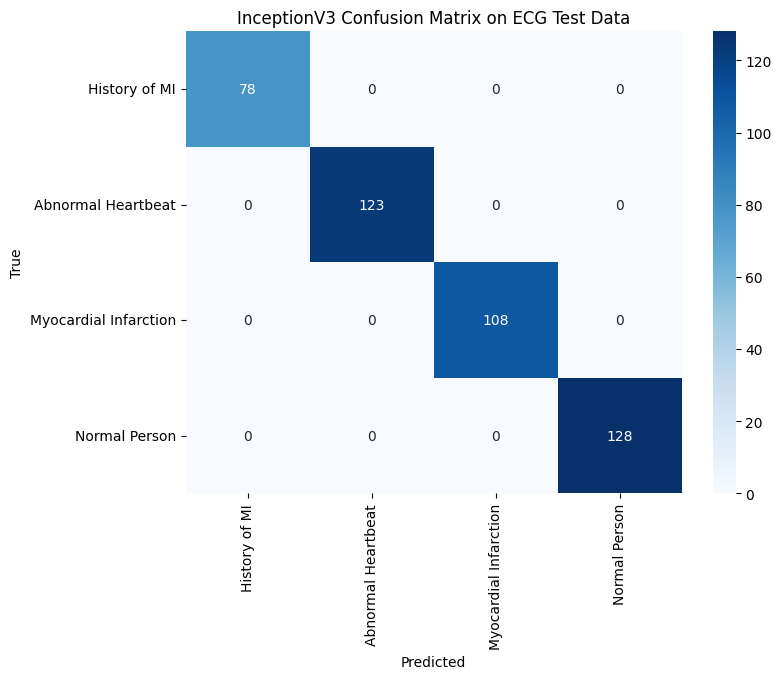

In [29]:
# Load best model
model.load_state_dict(torch.load("best_inceptionv3_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[
    "History of MI", "Abnormal Heartbeat", "Myocardial Infarction", "Normal Person"
]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[
    "History of MI", "Abnormal Heartbeat", "Myocardial Infarction", "Normal Person"
], yticklabels=[
    "History of MI", "Abnormal Heartbeat", "Myocardial Infarction", "Normal Person"
])
plt.title("InceptionV3 Confusion Matrix on ECG Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()